# Multi Salmo microbetag networks analysis

## Functions

Load dependencies

In [215]:
# General
import os
import pandas as pd
from dataclasses import dataclass

# To parse network
try:
    from ndex2.cx2 import RawCX2NetworkFactory
except ImportError:
    %pip install ndex2
    from ndex2.cx2 import RawCX2NetworkFactory

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from plotnine import ggplot, aes, geom_point, theme_minimal, labs
import patchworklib as pw # instead of the grid with plot.subplots()
try:
    import venn
except ImportError:
    %pip install venn
    import venn
from venn import venn

Functions for the needs of the stats.

In [2]:
def load_cx2(filepath):
    """
    Load a .cx2 network with ndex2
    """
    factory = RawCX2NetworkFactory()
    net = factory.get_cx2network(filepath)
    return net

In [4]:
def parse_microbetag_edges(cx2, env_set, metabolites_set):
    """
    Gets a ndex2 object as retruned from loading a .cx2 microbetag annotated network 
    and returns

    Arguments: 
    - cx2 (ndex2.cx2.CX2Network): 
    - env_set (Set): 
    - metabolites_set (Set):
    
    Returns:
    - edge_id_2_number_of_complements (Dict)
    - edge_types (Dict): 
    - taxa_pairs_with_positive_weight (List): 
    - edge_id_2_cross_feeding_compounds (Dict):
    """

    edge_id_sign = {}
    edge_id_2_number_of_complements = {}
    edge_id_2_cross_feeding_compounds = {}
    edge_types = {
        "taxon_to_taxon": {"edges": [], "counts": 0},  # done
        "taxon_to_metabo": {"edges": [], "counts": 0},
        "taxon_to_env": {"edges": [], "counts": 0}, 
        "metabo_to_metabo": {"edges": [], "counts": 0}, # done
        "env_to_env": {"edges": [], "counts": 0},       # done
        "metabo_to_env": {"edges": [], "counts": 0}
    }

    source_target_edge_ids = {}
    taxa_pairs_with_positive_weight = []

    for _, edge in cx2.get_edges().items():
        
        edge_id = edge["id"]

        if "completes/competes with" == edge["v"]["interaction type"]:
            for k in edge["v"]:
                # NOTE For PATHWAY COMPLEMENTS
                # if "compl::" in k:
                #     edge_id_2_number_of_complements[edge_id] = len(edge["v"][k])
                uniq_cross_feeding_compounds = set()
                if k.startswith("seedCompl::"):
                    edge_id_2_number_of_complements[edge_id] = len(edge["v"][k])
                    for compl in edge["v"][k]:
                        for i in compl.split("^")[2].split(";"): uniq_cross_feeding_compounds.add(i)
                    edge_id_2_cross_feeding_compounds[edge_id] = uniq_cross_feeding_compounds
        else:
            if 'microbetag::weight' in edge["v"]:
                if edge["v"]["microbetag::weight"] > 0:
                    edge_id_sign[edge_id] = 1
                    taxa_pairs_with_positive_weight.append((edge["s"], edge["t"]))
                else:
                    edge_id_sign[edge_id] = -1

        source_target_edge_ids[(edge["s"], edge["t"])] = edge_id

        source, target = edge["s"], edge["t"]
        
        node_source = cx2.get_nodes()[source]
        source_name = node_source["v"]["name"]
        
        node_target = cx2.get_nodes()[target]
        target_name = node_target["v"]["name"]
        
        if source_name not in env_set | metabolites_set and target_name not in env_set | metabolites_set:
            edge_types["taxon_to_taxon"]["counts"] += 1
            edge_types["taxon_to_taxon"]["edges"].append(edge_id)

        elif source_name in env_set and target_name in env_set:
            edge_types["env_to_env"]["counts"] += 1
            edge_types["env_to_env"]["edges"].append(edge_id)

        elif source_name in metabolites_set and target_name in metabolites_set:
            edge_types["metabo_to_metabo"]["counts"] += 1
            edge_types["metabo_to_metabo"]["edges"].append(edge_id)

        elif {source_name, target_name} <= env_set | metabolites_set and source_name in env_set ^ metabolites_set:
            edge_types["metabo_to_env"]["counts"] += 1
            edge_types["metabo_to_env"]["edges"].append(edge_id)

        elif {source_name, target_name} & env_set and not {source_name, target_name} & metabolites_set:
            edge_types["taxon_to_env"]["counts"] += 1
            edge_types["taxon_to_env"]["edges"].append(edge_id)

        elif {source_name, target_name} & metabolites_set and not {source_name, target_name} & env_set:
            edge_types["taxon_to_metabo"]["counts"] += 1
            edge_types["taxon_to_metabo"]["edges"].append(edge_id)

        else:
            print("PROBLEM:", source_name, target_name)

    return edge_id_2_number_of_complements, edge_types, taxa_pairs_with_positive_weight, edge_id_2_cross_feeding_compounds

In [5]:
def get_compls_and_compounds_in_positive_associated_taxa(cx2, positive_pairs, edge_id_compl_number, compounds):

    number_of_complements_in_positive_associated_taxa = 0
    unique_compounds = set()
    for _, edge in cx2.get_edges().items():

        s_t = (edge["s"], edge["t"])
        t_s = (edge["t"], edge["s"])
        edge_id = edge["id"]

        if s_t in positive_pairs or t_s in positive_pairs:
            if edge["v"]["interaction type"] == "completes/competes with":
                for k in edge["v"]:
                    if k.startswith("seedCompl::"):
                        number_of_complements_in_positive_associated_taxa += edge_id_compl_number[edge_id]
                        for i in compounds[edge_id]:
                            unique_compounds.add(i)

    return number_of_complements_in_positive_associated_taxa, unique_compounds

A `dataclass` for the parsed microbetag annotated network once loaded with `ndex2`; instances of this class will store outputs of the `parse_microbetag_egdes()`.

In [6]:
@dataclass
class MggParser():

    import ndex2

    num_total_compls: dict
    edge_types: dict
    pos_pairs_node_ids: list  # of tuples
    edge_id_to_unique_compounds: dict
    cx2: ndex2.cx2.CX2Network

    def __init__(self, cx2, env_set, metabolites_set) -> None:
        
        (
            self.num_total_compls,
            self.edge_types,
            self.pos_pairs_node_ids, 
            self.edge_id_to_unique_compounds 
         ) = parse_microbetag_edges(cx2, env_set, metabolites_set)
        self.cx2 = cx2

## Discussing the nets

***Salmonella*** is *positively* associated with **lactic acid**; in agreement with in vitro data. 

It’s also *negatively* associated with ***Lactobacillus johnsonii***, with a stronger negative than positive seed score. That means that *Lactobacillus johnsonii* is another probiotic candidate species.

*Salmonella* is also *negatively* associated with **time**, which is not unexpected.

***Ligilactobacillus salivarius*** (PoultryStar member) is *positively* associated to **synbiont-water**, in addition to **TG4** (no PoultryStar), so it does show up in some chickens supposed to have received it. 
Maybe that means that it is present in some hosts prior to treatment. 

**TG1** is linked to *Tyzzerella sp.* both in the global network and day 7 network.

Early days are more strongly shaped by treatment groups than later days.

Also, there are more taxon-metabolite associations in later days, with a peak in day 21.

There is a jump in node and edge number from 7 to 21 days, though the overall (Pearson) correlation of day to edge or node number is not significant.
Thus, the network gets more complex with changing feeding habits.


It seems that from day 28 to 35, even the number of edges is decreasing, the potential cross feedings are increased.

## Stats

### Prep

Keep track of the non-sequence nodes.

In [95]:
env_var = ["treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
           "day", "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
"L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", "L-Leucine", "L-Glutamic acid", "L-Glutamine", 
"L-Histidine", "L-Lysine", "L-Methionine", "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
"L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

In [12]:
root_dir = os.getcwd()
cx_dir = os.path.join(root_dir, "microbetag_nets")
# cx_dir = "/home/luna.kuleuven.be/u0156635/Documents/projects/3D-omics-general/results"

### Per day networks

#### Prep

Calculate statistics on the microbetag-annotated networks per day.

Load the `.cx2` files 

In [176]:
cx_07_filepath = os.path.join(cx_dir, "microbetag_net_day_7.cx2")  ; cx_07 = load_cx2(cx_07_filepath)
cx_14_filepath = os.path.join(cx_dir, "microbetag_net_day_14.cx2") ; cx_14 = load_cx2(cx_14_filepath)
cx_21_filepath = os.path.join(cx_dir, "microbetag_net_day_21.cx2") ; cx_21 = load_cx2(cx_21_filepath)
cx_28_filepath = os.path.join(cx_dir, "microbetag_net_day_28.cx2") ; cx_28 = load_cx2(cx_28_filepath)
cx_35_filepath = os.path.join(cx_dir, "microbetag_net_day_35.cx2") ; cx_35 = load_cx2(cx_35_filepath)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

In [17]:
days = [7, 14, 21, 28, 35]

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [14]:
days_parsed_nets = {
    "day07" : MggParser(cx_07, env_set, metabolites_set),
    "day14" : MggParser(cx_14, env_set, metabolites_set),
    "day21" : MggParser(cx_21, env_set, metabolites_set),
    "day28" : MggParser(cx_28, env_set, metabolites_set),
    "day35" : MggParser(cx_35, env_set, metabolites_set)
}

In [15]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in days_parsed_nets.items()
]

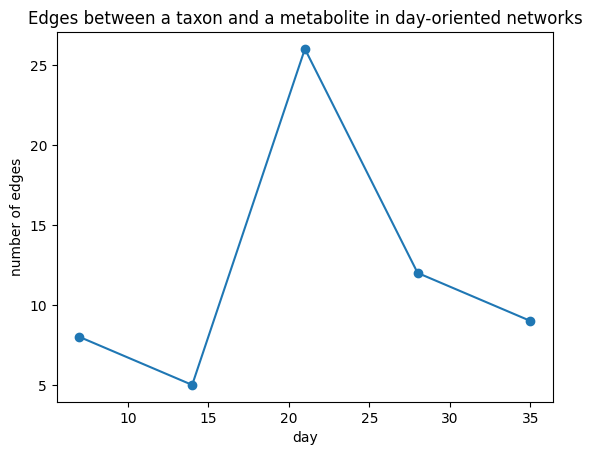

In [18]:
# What to plot
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")
# Show time
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [19]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in days_parsed_nets.items()
]

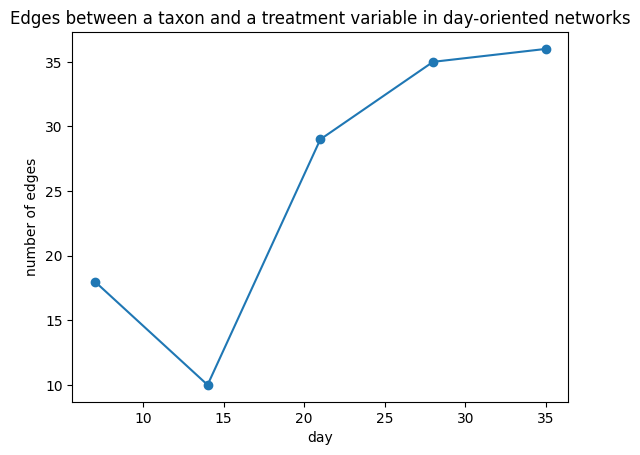

In [20]:
# What to plot
plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")
# Show time
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [21]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in days_parsed_nets.items()
]

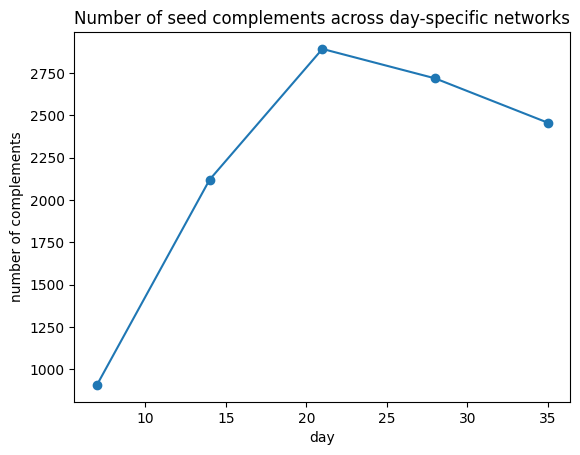

In [22]:
# What to plot
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")
# Show time
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [23]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in days_parsed_nets.items()
]

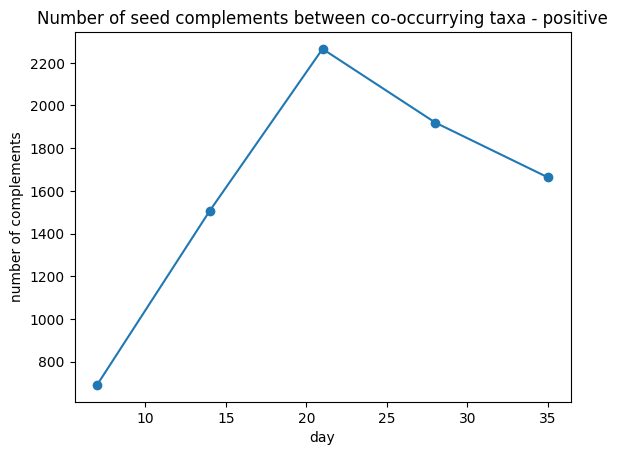

In [24]:
# What to plot
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")
# Show time
plt.show()

In [25]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(days_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(days_parsed_nets.values())
]

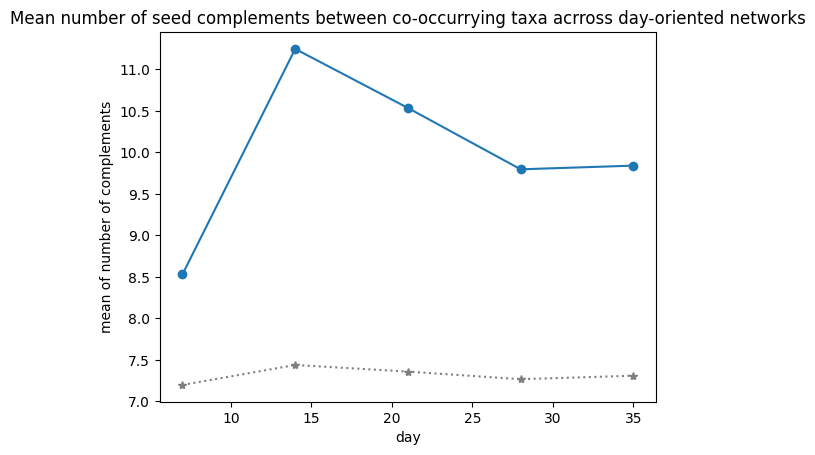

In [26]:
# What to plot
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")
# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross day-oriented networks")
# Show time
plt.show()

#### Unique compounds involved in potential cross-feedings

In [28]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in days_parsed_nets.items()
]

In [29]:
lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

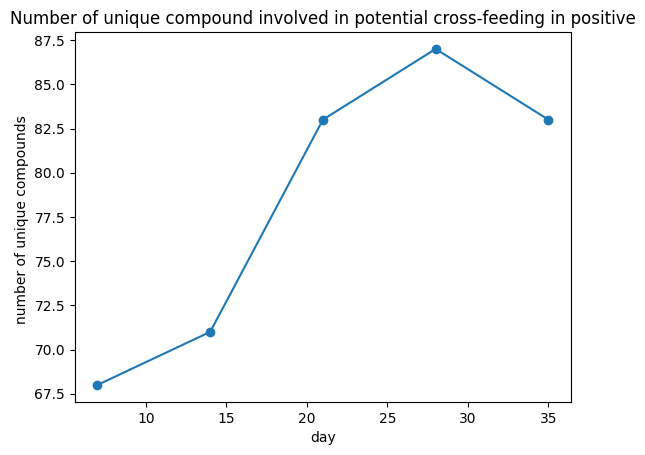

In [30]:
plt.plot(days, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [31]:
day_set = { "day_" + str(i): j for i,j in zip(days, unique_compounds_in_cf_of_positive_associated_taxa)}

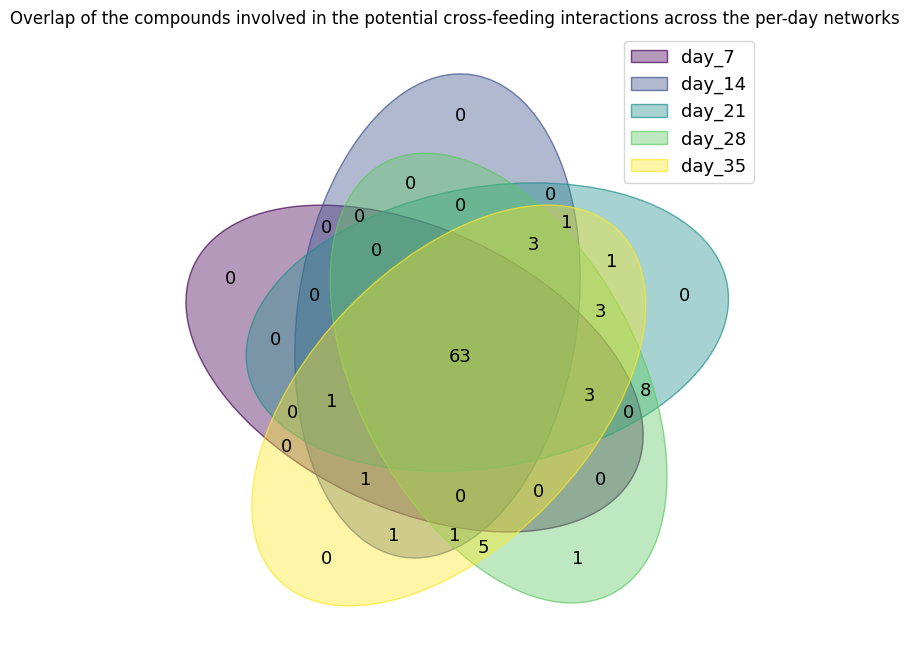

In [32]:
venn(day_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-day networks")

# Show the plot
plt.show()

In [120]:
days_parsed_nets.keys()

dict_keys(['day07', 'day14', 'day21', 'day28', 'day35'])

In [348]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# fig_ratio, axes_ratio = plt.subplots(2, 3, figsize=(15,10))
# axes_ratio = axes_ratio.flatten()

dfs = []
ggplots = []
ratio_ggplots = []

for idx, day in enumerate(days_parsed_nets):
    day_net = days_parsed_nets[day]

    number_of_neighbors_pos = {}
    for edge in day_net.pos_pairs_node_ids:
        for x in edge:
            node = day_net.cx2.get_node(x)
            if node["v"]["name"] in metabolites or node["v"]["name"] in env_set:
                continue
            if x not in number_of_neighbors_pos:
                number_of_neighbors_pos[x] = {}
                number_of_neighbors_pos[x]["neighbors_num"] = 1
                number_of_neighbors_pos[x]["seed_compls_num"] = 0
                number_of_neighbors_pos[x]["name"] = node["v"]["name"]
                number_of_neighbors_pos[x]["species"] = node["v"]["taxonomy::species"]
                number_of_neighbors_pos[x]["family"] = node["v"]["taxonomy::family"]
            else:
                number_of_neighbors_pos[x]["neighbors_num"] += 1
    
    for edge_id in day_net.edge_types["taxon_to_taxon"]["edges"]:
        edge = day_net.cx2.get_edge(edge_id)
        source, target = edge["s"], edge["t"]
        if source in number_of_neighbors_pos and target in number_of_neighbors_pos:
            if edge["v"]["interaction type"] not in [ "cooccurrence" , "depletion"]:
                for case, items in edge["v"].items(): 
                    if case.startswith("seedCompl"):
                        number_of_neighbors_pos[source]["seed_compls_num"] += len(items)
                        number_of_neighbors_pos[target]["seed_compls_num"] += len(items)
    
    df = pd.DataFrame.from_dict(number_of_neighbors_pos, orient="index")
    df["day"] = day
    df["compl_ratio"] = df["seed_compls_num"] / df["neighbors_num"]

    plot = (
        ggplot(df, aes(x='neighbors_num', y='seed_compls_num', color='family')) +
        geom_point(size=3) +  # Adjust point size if needed
        theme_minimal() +  # Use a clean theme
        labs(title=f'{day} at the family level', 
            x='Neighbors Number', 
            y='Seed Complements Number')
    )
    ggplots.append(plot)


    rplot = (
        ggplot(df, aes(x='neighbors_num', y='compl_ratio', color='family')) +
        geom_point(size=3) +  # Adjust point size if needed
        theme_minimal() +  # Use a clean theme
        labs(title=f'{day} at the family level', 
            x='Neighbors Number', 
            y='Seed Complements Ratio')
    )
    ratio_ggplots.append(rplot)


    dfs.append(df)



In [ ]:
# Abs
g0 = pw.load_ggplot(ggplots[0], figsize=(2,3))
g1 = pw.load_ggplot(ggplots[1], figsize=(2,3))
g2 = pw.load_ggplot(ggplots[2], figsize=(2,3))
g3 = pw.load_ggplot(ggplots[3], figsize=(2,3))
g4 = pw.load_ggplot(ggplots[4], figsize=(2,3))

# Ratios 
rg0 = pw.load_ggplot(ratio_ggplots[0], figsize=(2,3))
rg1 = pw.load_ggplot(ratio_ggplots[1], figsize=(2,3))
rg2 = pw.load_ggplot(ratio_ggplots[2], figsize=(2,3))
rg3 = pw.load_ggplot(ratio_ggplots[3], figsize=(2,3))
rg4 = pw.load_ggplot(ratio_ggplots[4], figsize=(2,3))

In [341]:
empty_plot = ggplot()

# Load it into patchworklib
empty = pw.load_ggplot(empty_plot)


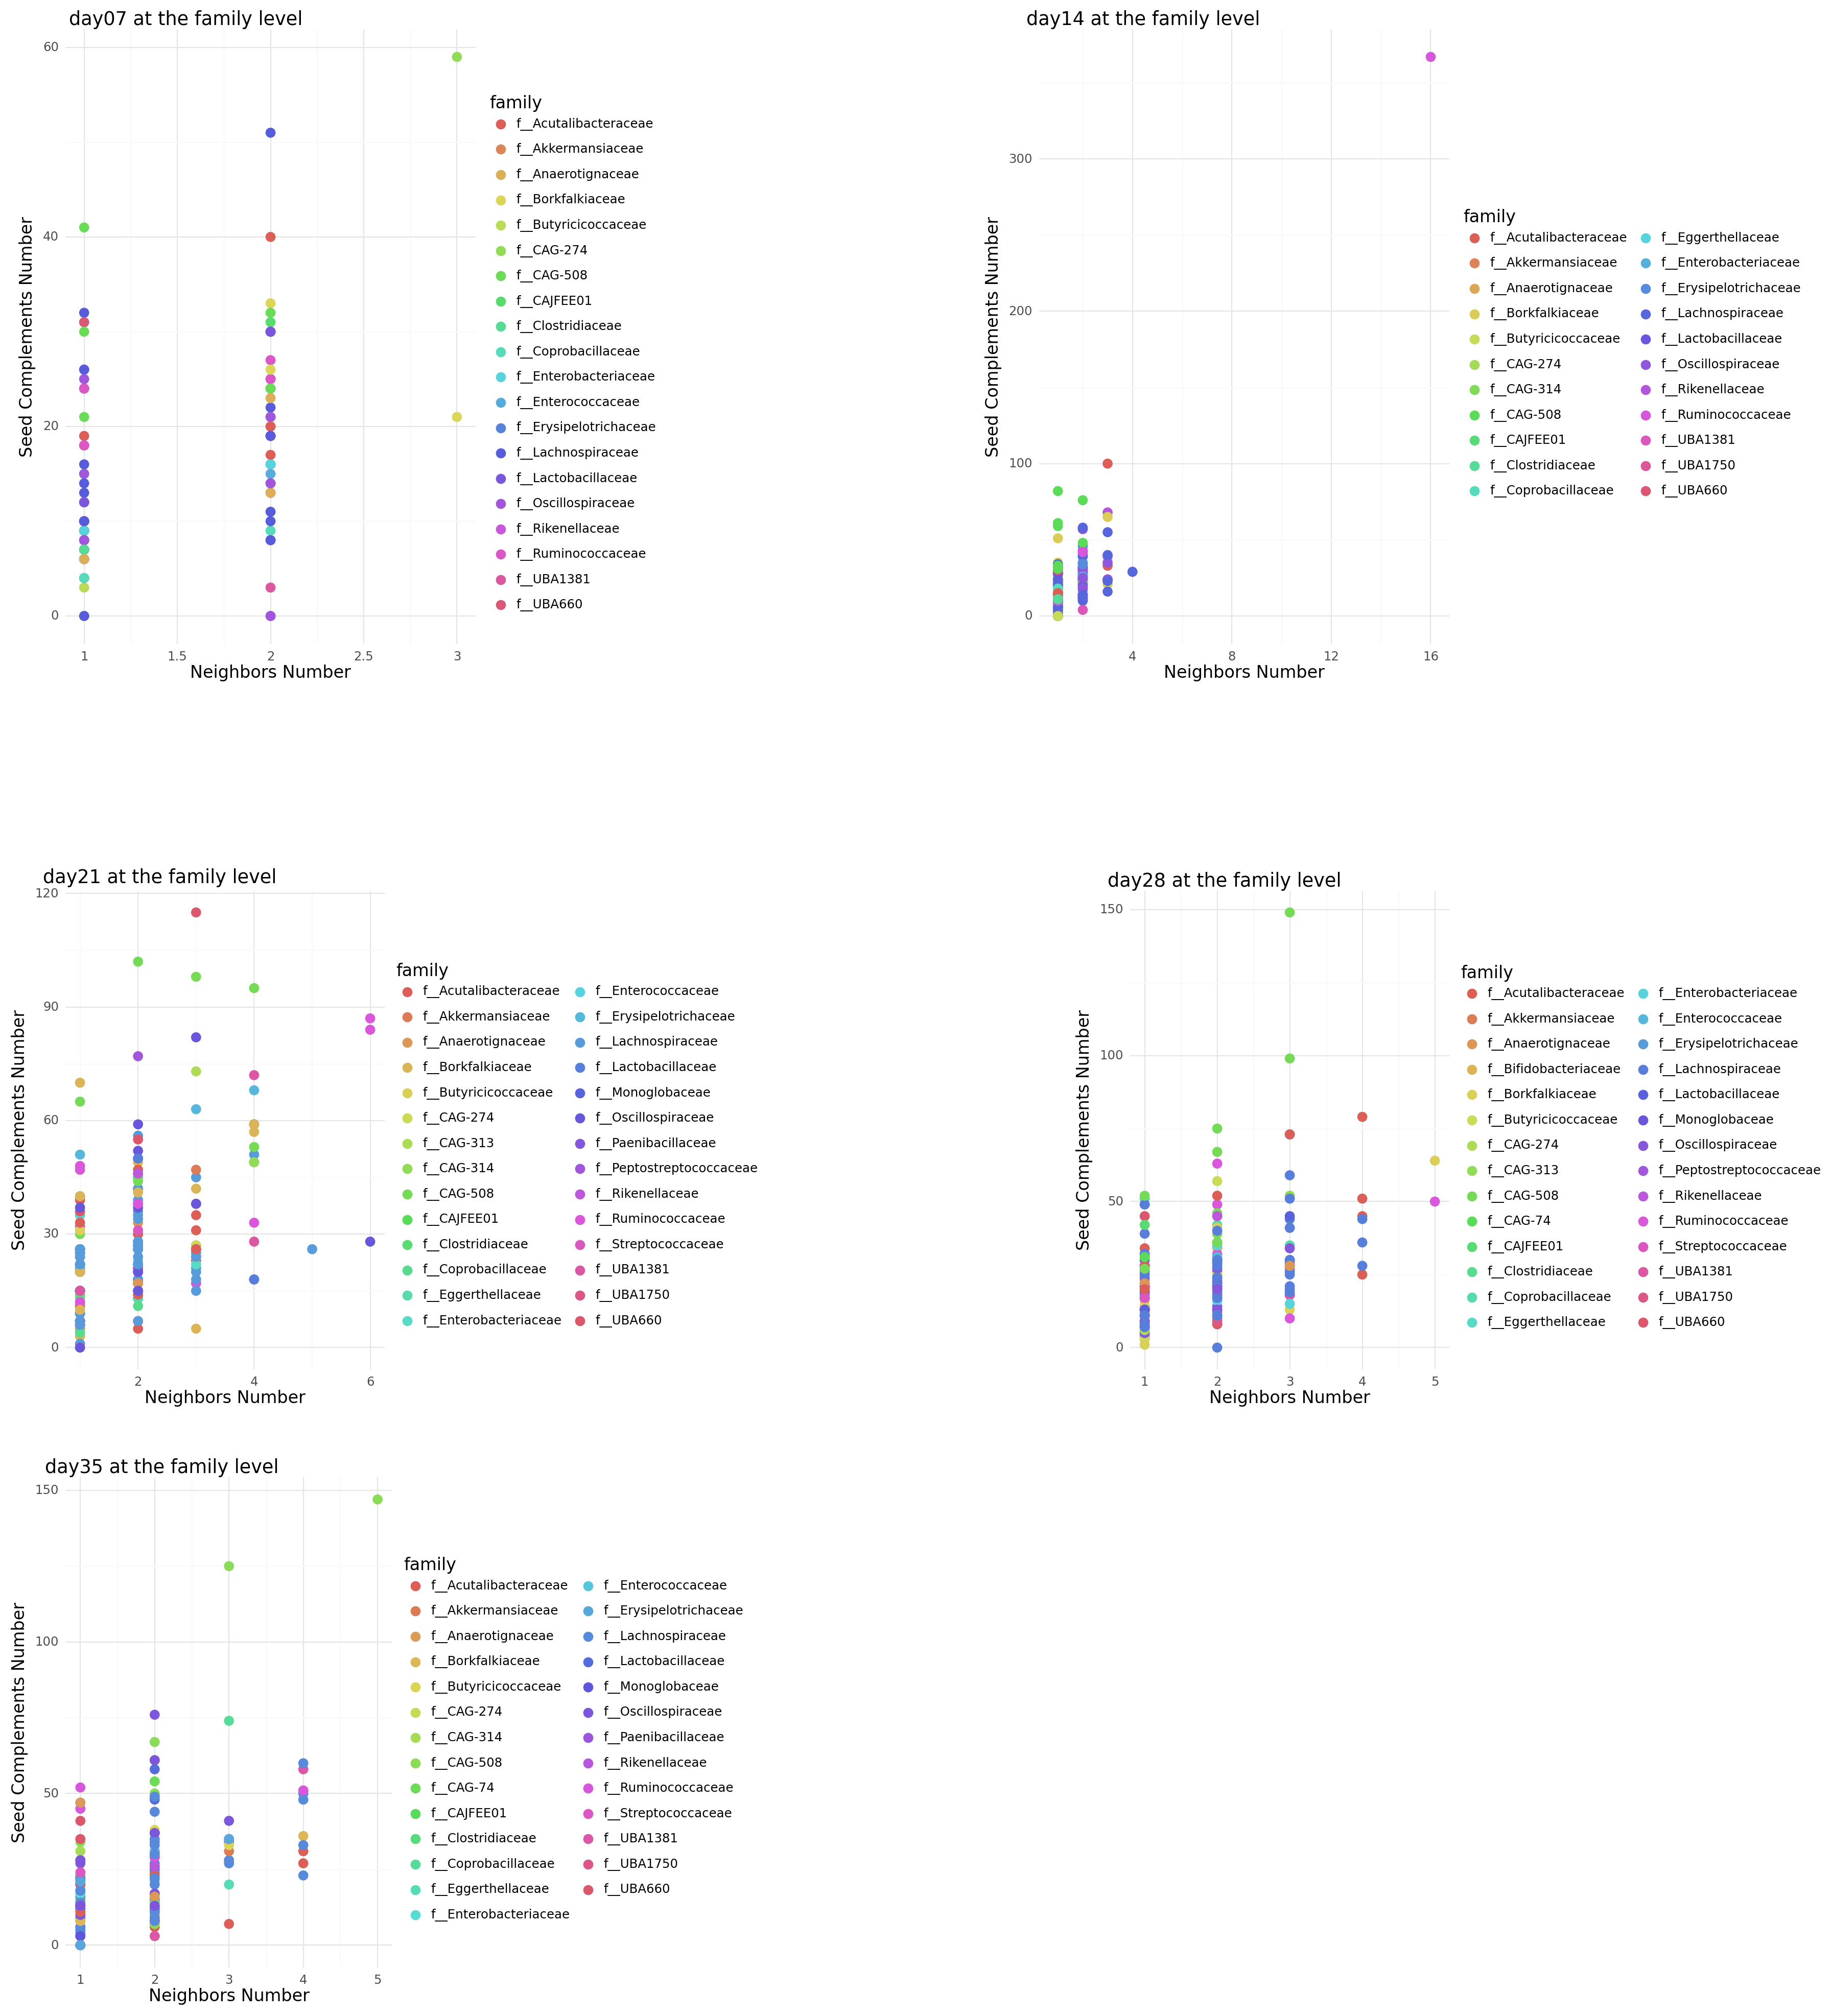

In [350]:
g1234 = (g0|g1)/(g2|g3)/(g4| empty)
g1234.savefig("family_neighbors_number_of_seed_compls", dpi=300)
g1234

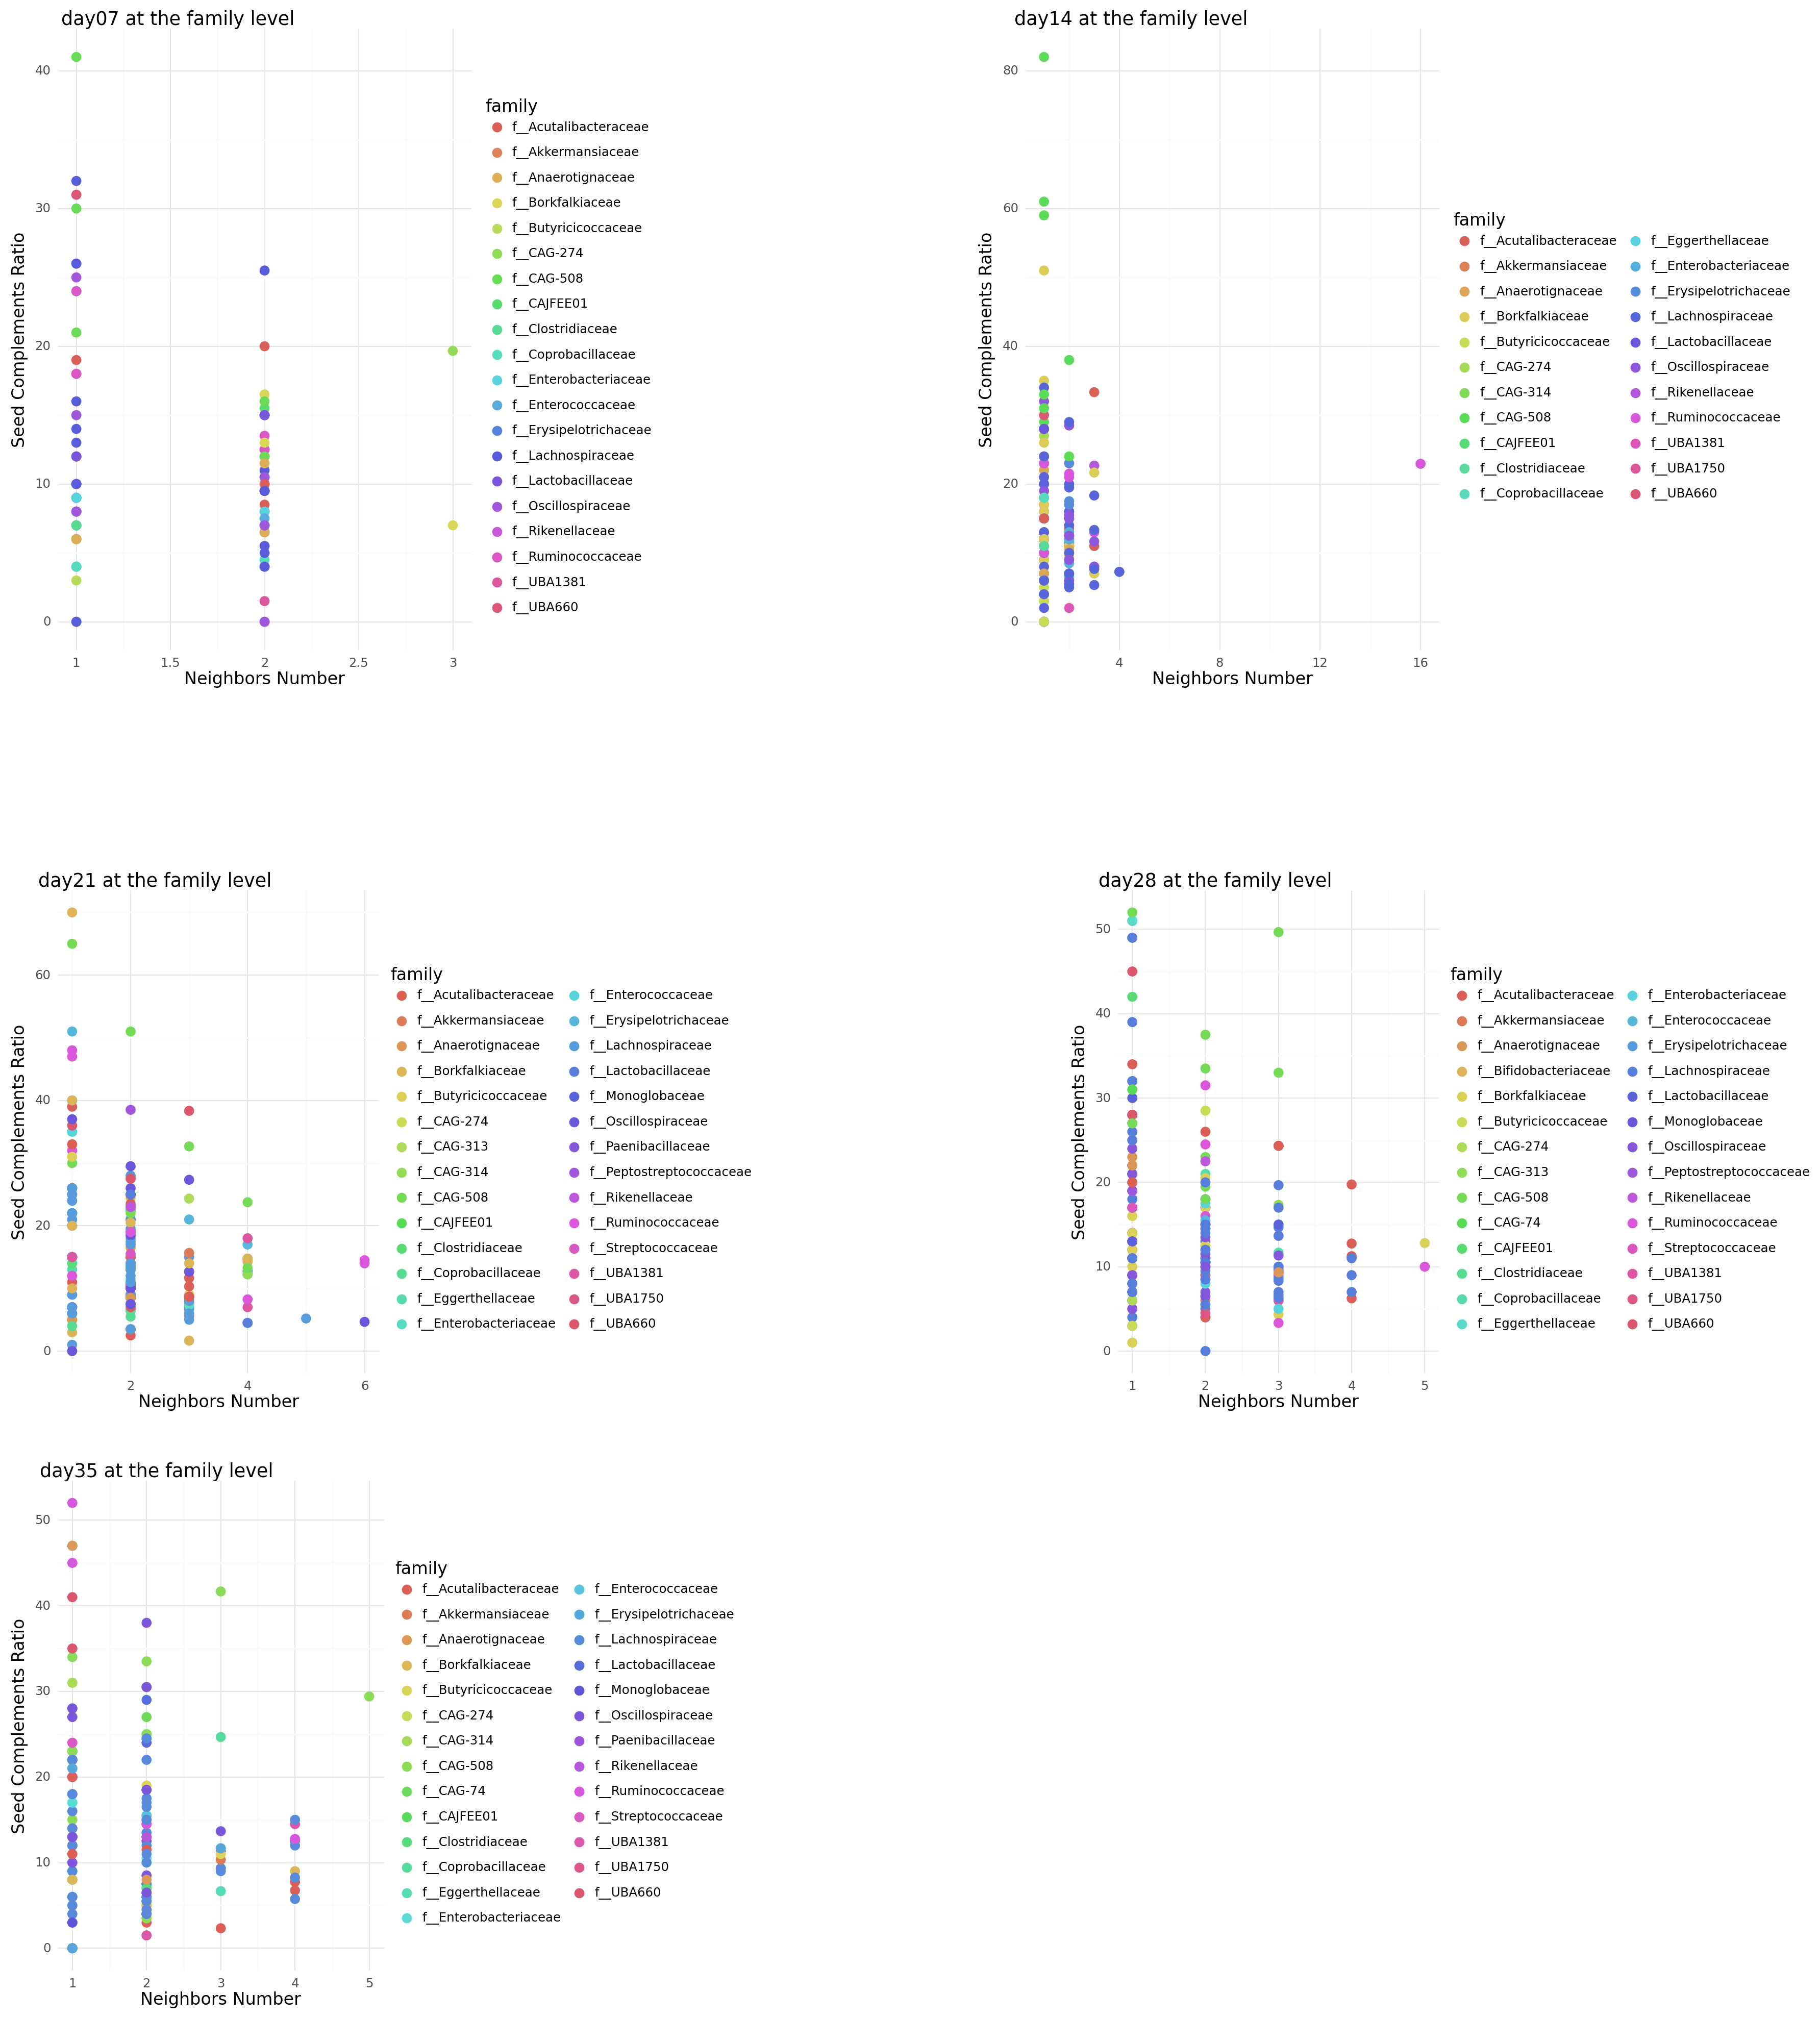

In [351]:
rg1234 = (rg0|rg1)/(rg2|rg3)/(rg4|empty)
g1234.savefig("family_neighbors_ratio_of_seed_compls", dpi=300)
rg1234

In [135]:
dfs[1][dfs[1]["neighbors_num"]>15]

neighbors_num  seed_compls_num                name  \
177             16              367  D300418:bin_000001   

                       species              family    day  compl_ratio  
177  s__Faeciplasma gallinarum  f__Ruminococcaceae  day14      22.9375

In [220]:
# cx_07
# days_parsed_nets["day07"].edge_types.keys()

taxa_pair_2_edge_id = {}
for edge_id in cx_07.get_edges():
    edge = cx_07.get_edge(edge_id)    
    pair = (edge["s"], edge["t"])
    if edge["v"]["interaction type"] != "completes/competes with":    
        taxa_pair_2_edge_id[pair] = edge_id


pos_weight_scores, neg_weight_scores = {}, {}
for edge_id in days_parsed_nets["day07"].edge_types["taxon_to_taxon"]["edges"]:
    edge = cx_07.get_edge(edge_id)
    if edge["v"]["interaction type"] in ["cooccurrence", "depletion"]:
        continue

    comp, coop, s, t = edge["v"]["seed::competition"], edge["v"]["seed::cooperation"], edge["s"], edge["t"]
    eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

    flashweave_score = cx_07.get_edge(eid)["v"]["microbetag::weight"]
    target = pos_weight_scores if flashweave_score > 0 else neg_weight_scores
    target[edge_id] = {"cooperation": coop, "competition": comp}
    
    if flashweave_score > 0:
        target[edge_id]["cooccurrence"] = flashweave_score
    else:
        target[edge_id]["depletion"] = flashweave_score


In [209]:
df = pd.DataFrame.from_dict(pos_weight_scores, orient="index")
df.head()

cooperation         competition  cooccurrence
1   0.0735294117647058              0.7375      0.864425
2                  0.1  0.7763157894736842      0.864425
4   0.2203389830508474  0.5769230769230769      0.870920
5   0.2698412698412698  0.6428571428571429      0.870920
10  0.1538461538461538                0.72      0.816269

In [212]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df["cooperation"], df["cooccurrence"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["cooperation"], df["cooccurrence"])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.037341385584370834
Spearman correlation: -0.07297445661875661


In [213]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df["competition"], df["cooccurrence"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["competition"], df["cooccurrence"])
print("Spearman correlation:", spearman_corr)

Pearson correlation: 0.08291897960596203
Spearman correlation: 0.0966910196206623


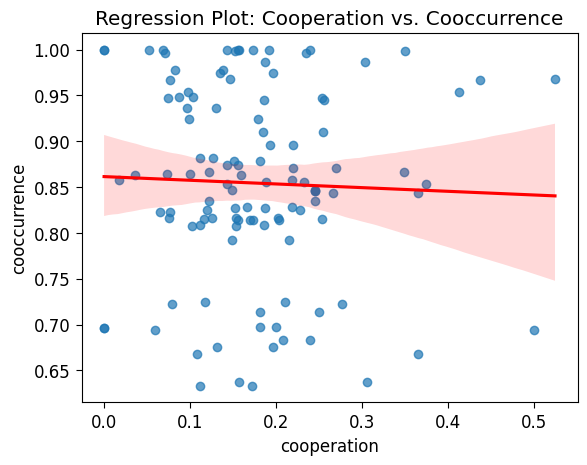

In [216]:
sns.regplot(x=df["cooperation"], y=df["cooccurrence"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [221]:
from scipy.stats import pearsonr, spearmanr
df = pd.DataFrame.from_dict(neg_weight_scores, orient="index")
df = df.astype(float) 
df.head()

pearson_corr, _ = pearsonr(df["cooperation"], df["depletion"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["cooperation"], df["depletion"])
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.321522862411514
Spearman correlation: -0.22929268568287528


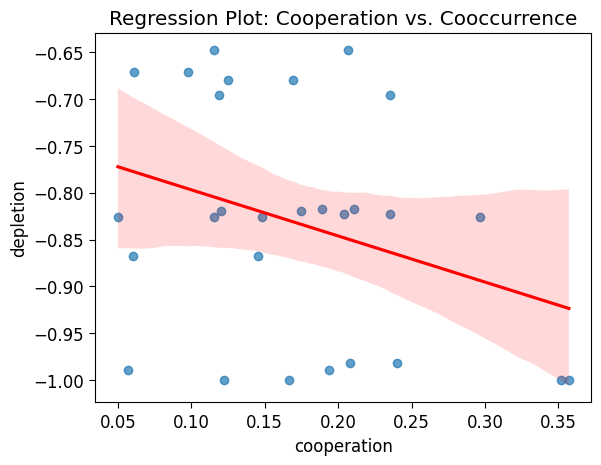

In [224]:
sns.regplot(x=df["cooperation"], y=df["depletion"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

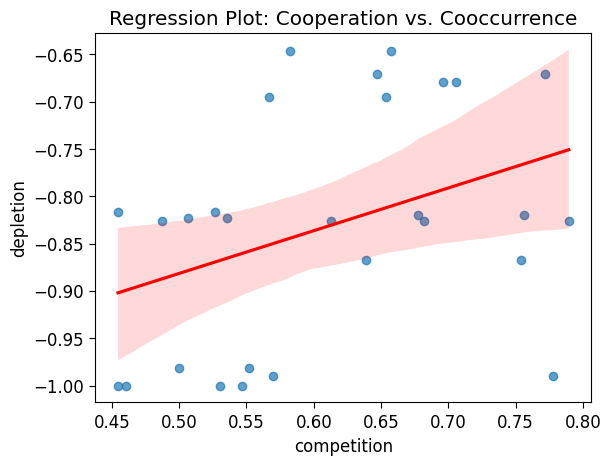

In [225]:
sns.regplot(x=df["competition"], y=df["depletion"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [247]:
def compute_weight_scores(cx_net, parsed_net):
    """
    Computes positive and negative weight scores for a given network.

    Parameters:
        cx_net: Network object containing edges.
        parsed_net: Parsed network dictionary with edge types.

    Returns:
        pos_weight_scores, neg_weight_scores: Dictionaries containing computed scores.
    """

    # Create a mapping of taxa pairs to edge IDs
    taxa_pair_2_edge_id = {
        (edge["s"], edge["t"]): edge_id
        for edge_id in cx_net.get_edges()
        if (edge := cx_net.get_edge(edge_id))["v"]["interaction type"] != "completes/competes with"
    }

    pos_weight_scores, neg_weight_scores = {}, {}

    for edge_id in parsed_net.edge_types["taxon_to_taxon"]["edges"]:
        edge = cx_net.get_edge(edge_id)
        if edge["v"]["interaction type"] in ["cooccurrence", "depletion"]:
            continue

        comp, coop, s, t = edge["v"]["seed::competition"], edge["v"]["seed::cooperation"], edge["s"], edge["t"]
        eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

        flashweave_score = cx_net.get_edge(eid)["v"]["microbetag::weight"]
        target = pos_weight_scores if flashweave_score > 0 else neg_weight_scores
        target[edge_id] = {"cooperation": coop, "competition": comp, "cooccurrence" if flashweave_score > 0 else "depletion": flashweave_score}

    return {"pos": pos_weight_scores, "neg":neg_weight_scores}


In [248]:
day_cx_objects = {
    "day07": cx_07,
    "day14": cx_14,
    "day21": cx_21,
    "day28": cx_28,
    "day35": cx_35
}

all_scores = {
    day: compute_weight_scores(cx_net, days_parsed_nets[day])
    for day, cx_net in day_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

In [306]:
import scipy.stats as stats

def plot_regression(ax, df, x_col, y_col, title):
    """Plots a regression plot on the given Axes object and includes p-value and R-squared."""
    # Perform linear regression to get p-value and R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x_col], df[y_col])
    r_squared = r_value**2
    
    # Create the regression plot
    sns.regplot(x=df[x_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"}, ax=ax)
    
    # Add p-value and R-squared to the title
    ax.set_title(f"{title}\n$R^2$ = {r_squared:.2f}, p-value = {p_value:.4f}")

# def plot_regression(ax, df, x1_col, x2_col, y_col, title, color1="red", color2="blue"):
#     """Plots two regression plots on the same Axes object and includes p-value & R-squared."""
    
#     # First regression (x1_col vs y_col)
#     slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df[x1_col], df[y_col])
#     r_squared1 = r_value1**2
#     sns.regplot(x=df[x1_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color1}, ax=ax, label=f"{x1_col} (R²={r_squared1:.2f}, p={p_value1:.4f})")
    
#     # Second regression (x2_col vs y_col)
#     slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df[x2_col], df[y_col])
#     r_squared2 = r_value2**2
#     sns.regplot(x=df[x2_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color2}, ax=ax, label=f"{x2_col} (R²={r_squared2:.2f}, p={p_value2:.4f})")
    
#     # Titles and legend
#     ax.set_title(title)
#     ax.legend()


def plot_dual_regression(ax, df, x_col, y1_col, y2_col, title, color1="blue", color2="red"):
    """Plots two regressions with separate y-axes: one for y1_col (left) and y2_col (right)."""
    
    # Left Y-axis (cooperation vs cooccurrence)
    ax1 = ax
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df[x_col], df[y1_col])
    r_squared1 = r_value1**2
    sns.regplot(x=df[x_col], y=df[y1_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color1}, ax=ax1)
    ax1.set_ylabel(y1_col, color=color1)
    ax1.tick_params(axis="y", colors=color1)
    
    # Right Y-axis (competition vs cooccurrence)
    ax2 = ax1.twinx()
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df[x_col], df[y2_col])
    r_squared2 = r_value2**2
    sns.regplot(x=df[x_col], y=df[y2_col], scatter_kws={"alpha": 0.3, "color": "red"}, line_kws={"color": color2}, ax=ax2)
    ax2.set_ylabel(y2_col, color=color2)
    ax2.tick_params(axis="y", colors=color2)

    # Titles
    ax1.set_xlabel(x_col)
    ax1.set_title(f"{title}\n{y1_col}: R²={r_squared1:.2f}, p={p_value1:.4f} | {y2_col}: R²={r_squared2:.2f}, p={p_value2:.4f}")




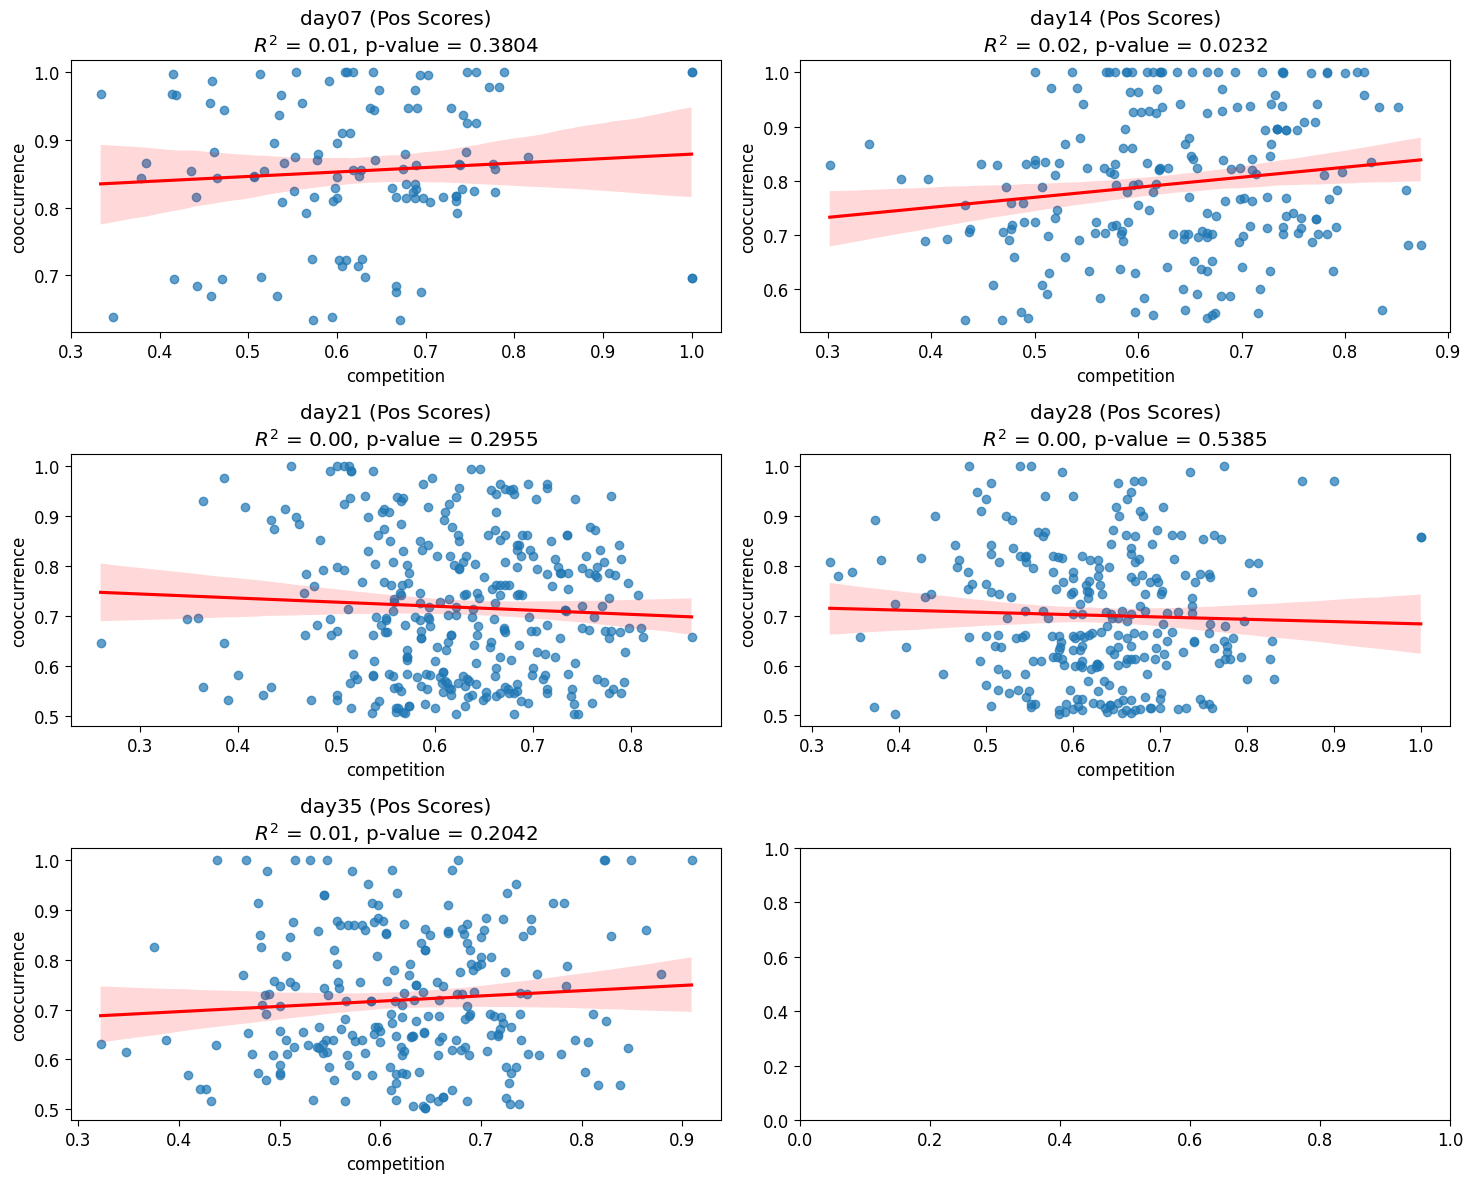

In [310]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not pos_df.empty:  # Plot positive weight scores
        plot_regression(axes[i], pos_df, "competition", "cooccurrence", f"{day} (Pos Scores)")
        # plot_regression(axes[i], pos_df, "cooperation", "cooccurrence", f"{day} (Pos Scores)")
        # plot_dual_regression(axes[i], pos_df, "cooccurrence", "cooperation", "competition", f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

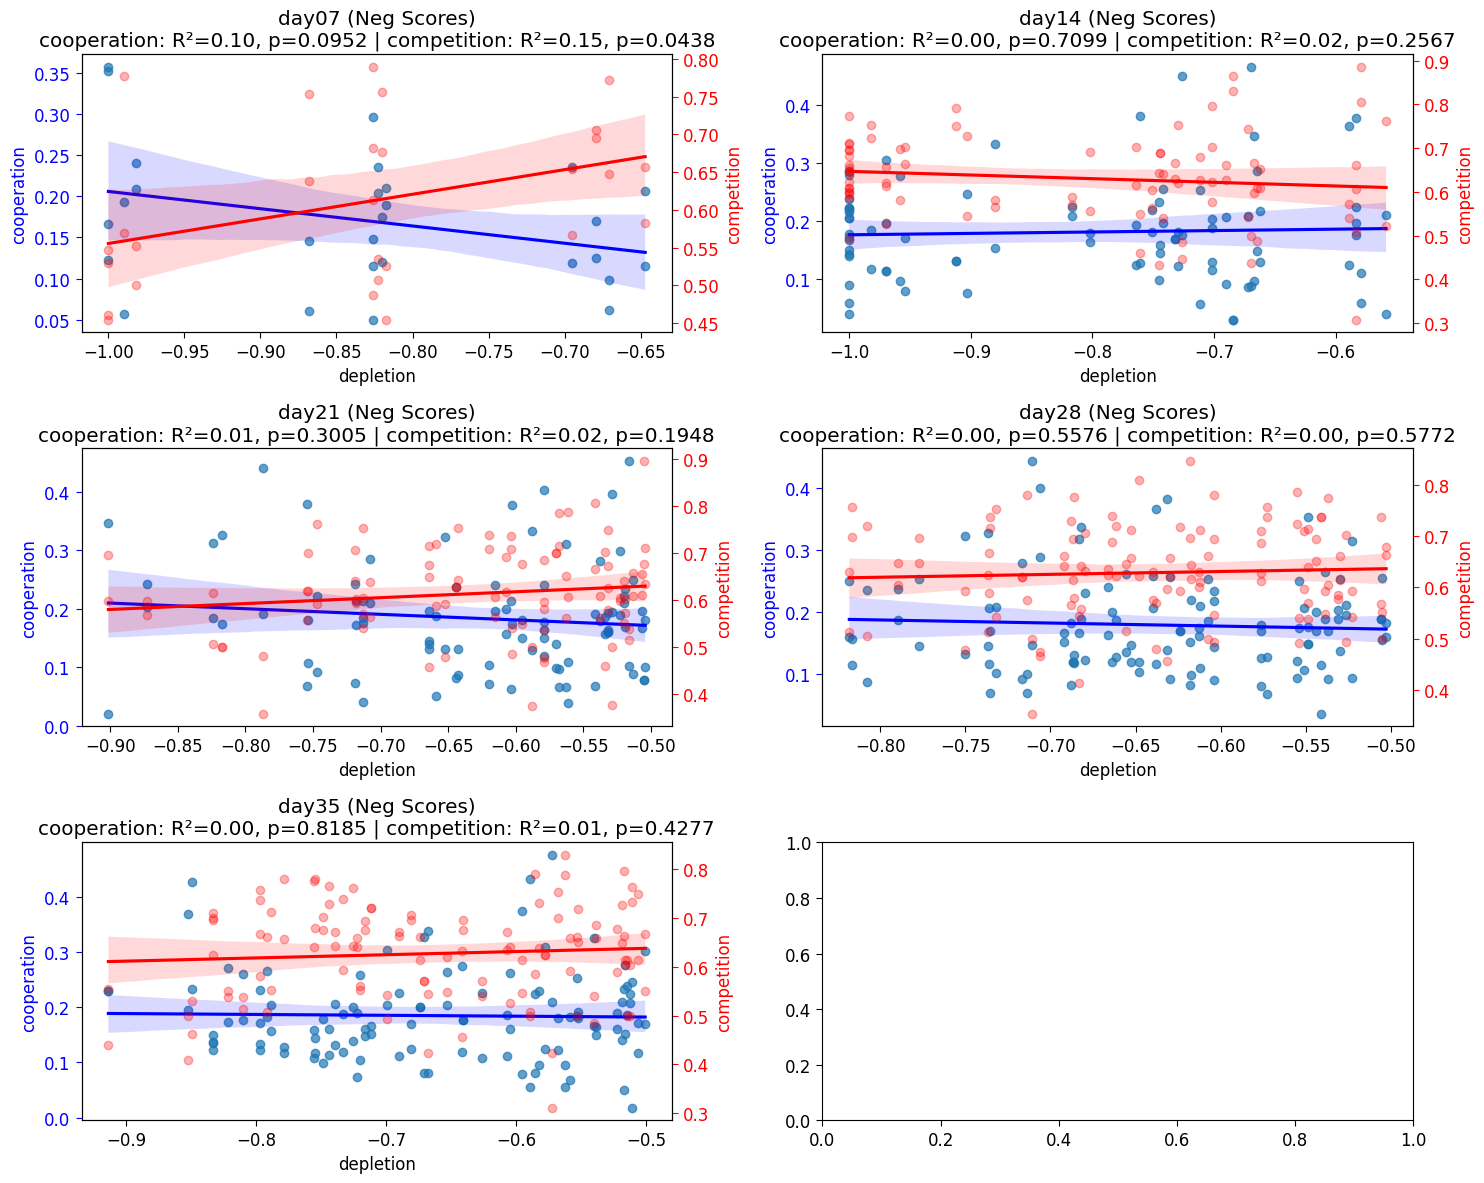

In [309]:

# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
 
    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, "competition", "depletion", f"{day} (Neg Scores)")
            # plot_regression(axes[i + 1], neg_df, "cooperation", "depletion", f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, "depletion", "cooperation", "competition", f"{day} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Per treatment

#### Prep

In [260]:
cx_tg1_filepath = os.path.join(cx_dir, "microbetag_net_TG1.cx2") ; cx_tg_1 = load_cx2(cx_tg1_filepath)
cx_tg2_filepath = os.path.join(cx_dir, "microbetag_net_TG2.cx2") ; cx_tg_2 = load_cx2(cx_tg2_filepath)
cx_tg3_filepath = os.path.join(cx_dir, "microbetag_net_TG3.cx2") ; cx_tg_3 = load_cx2(cx_tg3_filepath)
cx_tg4_filepath = os.path.join(cx_dir, "microbetag_net_TG4.cx2") ; cx_tg_4 = load_cx2(cx_tg4_filepath)
cx_tg5_filepath = os.path.join(cx_dir, "microbetag_net_TG5.cx2") ; cx_tg_5 = load_cx2(cx_tg5_filepath)

In [356]:
treatment_parsed_nets = {
    "TG1" : MggParser(cx_tg_1, env_set, metabolites_set),
    "TG2" : MggParser(cx_tg_2, env_set, metabolites_set),
    "TG3" : MggParser(cx_tg_3, env_set, metabolites_set),
    "TG4" : MggParser(cx_tg_4, env_set, metabolites_set),
    "TG5" : MggParser(cx_tg_5, env_set, metabolites_set)
}

In [357]:
treatment_cx_objects = {
    "TG1": cx_tg_1,
    "TG2": cx_tg_2,
    "TG3": cx_tg_3,
    "TG4": cx_tg_4,
    "TG5": cx_tg_5
}

In [358]:
all_scores_treatments = {
    treatment: compute_weight_scores(cx_net, treatment_parsed_nets[treatment])
    for treatment, cx_net in treatment_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

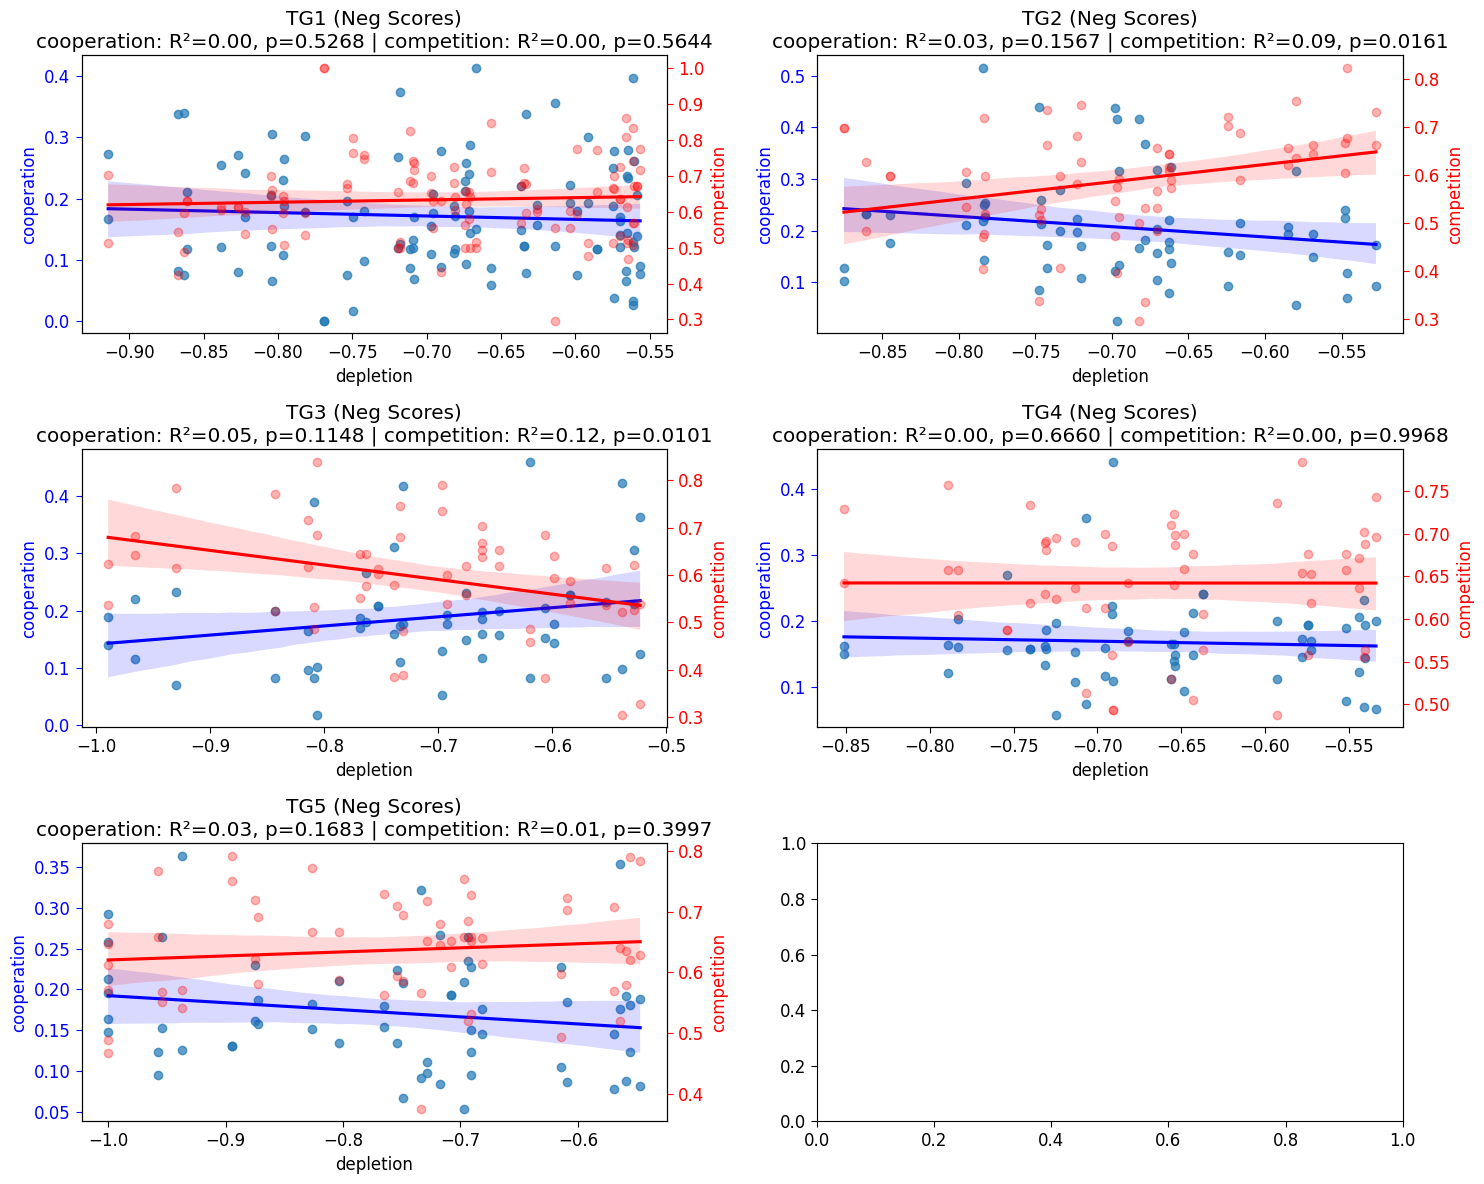

In [354]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, "competition", "depletion", f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, "depletion", "cooperation", "competition", f"{day} (Neg Scores)")

            

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

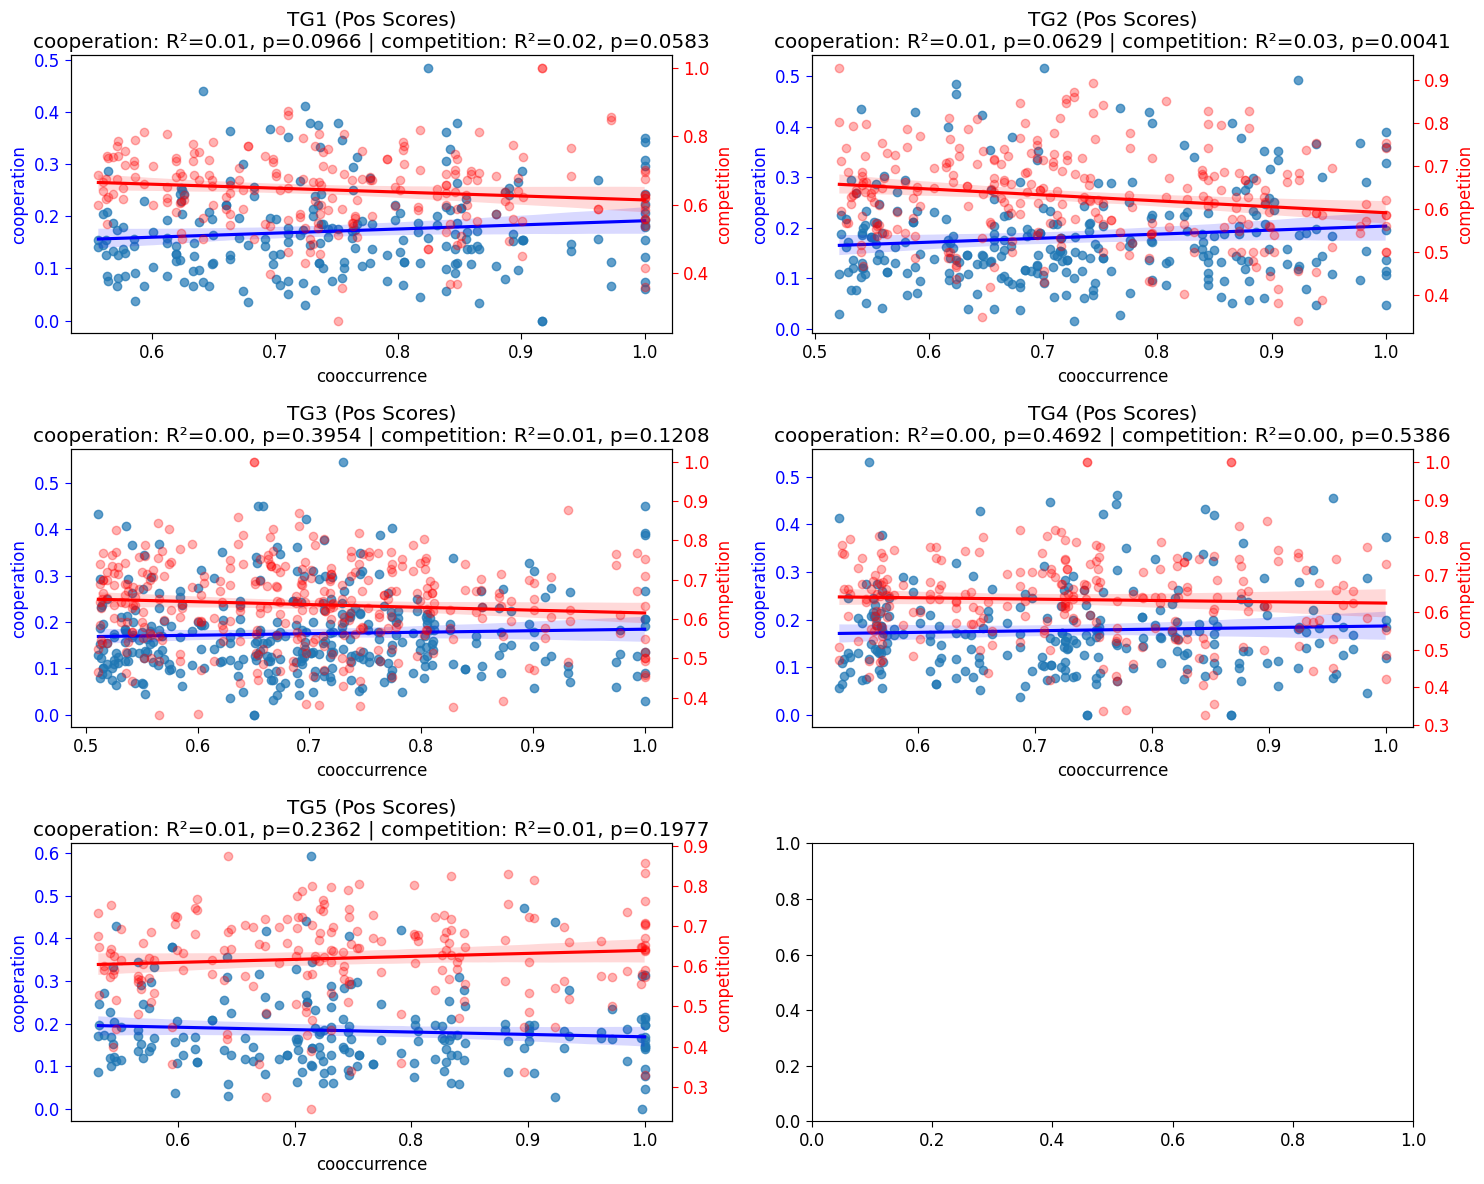

In [363]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break
    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    if not pos_df.empty:  # Plot positive weight scores
        # plot_regression(axes[i], pos_df, "cooperation", "cooccurrence", f"{day} (Pos Scores)")
        plot_dual_regression(axes[i], pos_df, "cooccurrence", "cooperation", "competition", f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [360]:
pos_df

cooperation  competition  cooccurrence
1       0.169231     0.641975      0.542909
2       0.100000     0.753623      0.542909
4       0.181818     0.697368      0.930933
5       0.142857     0.563830      0.930933
7       0.254237     0.641791      0.639670
..           ...          ...           ...
377     0.283333     0.600000      0.742562
379     0.241379     0.647059      0.845697
380     0.153846     0.556962      0.845697
382     0.246377     0.604651      0.570273
383     0.118644     0.658228      0.570273

[196 rows x 3 columns]

In [27]:
tg_microbetag_nets = [cx_tg_1, cx_tg_2, cx_tg_3, cx_tg_4, cx_tg_5]
treatments = ["TG1", "TG2", "TG3", "TG4", "TG5"]
treatments_descr = [
    "TG1:Salmonella, synbiont both water and feed",
    "TG2:Salmonella, synbiont in water",
    "TG3:Salmonella, synbiont in feed",
    "TG4:Salmonella, no symbiont",
    "TG5:No Salmonella, no symbiont"
]

In [28]:
parsed_tg_edges = []
for tg_mgg_net in tg_microbetag_nets:
    num_compl, types, pos_pairs, compounds = parse_microbetag_edges(tg_mgg_net, env_set=env_set, metabolites_set=metabolites_set)
    parsed_tg_edges.append([num_compl, types, pos_pairs, compounds])

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [30]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in treatment_parsed_nets.items()
]

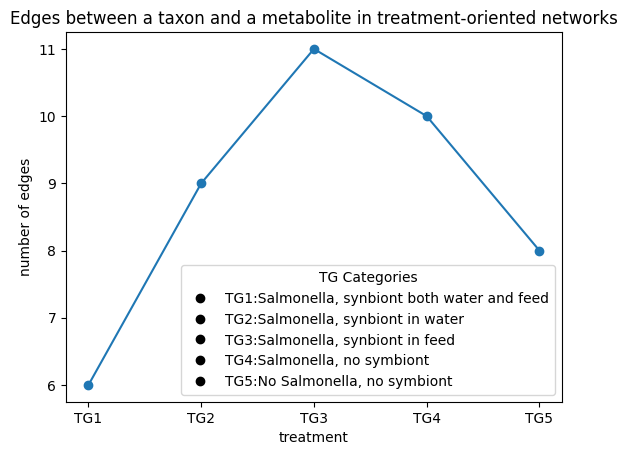

In [31]:
plt.plot(treatments, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in treatment-oriented networks")
# Create proxy artists for legend
legend_handles = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=t) for t in treatments_descr]
# Add legend box
plt.legend(handles=legend_handles, title="TG Categories", loc="lower right", frameon=True)
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [32]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in treatment_parsed_nets.items()
]

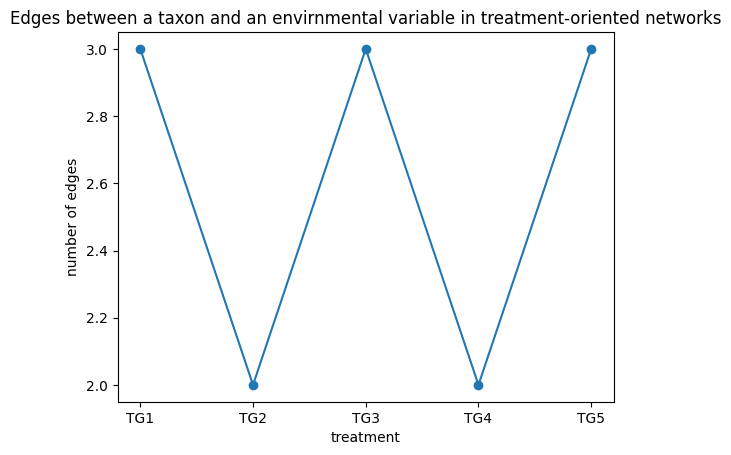

In [33]:
plt.plot(treatments, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and an envirnmental variable in treatment-oriented networks")

plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [34]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in treatment_parsed_nets.items()
]

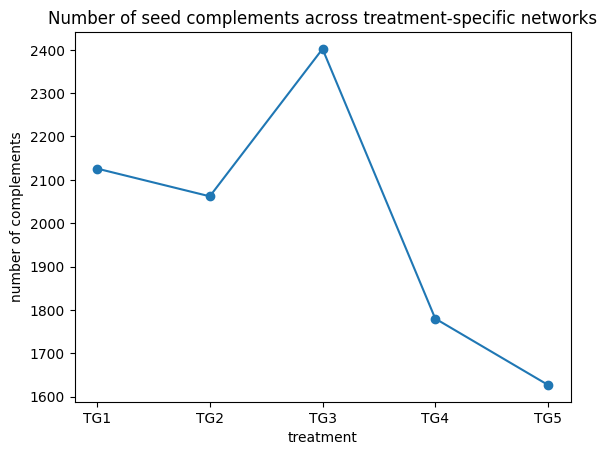

In [35]:
plt.plot(treatments, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements across treatment-specific networks")

# Show the plot
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [27]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in treatment_parsed_nets.items()
]

NameError: name 'treatment_parsed_nets' is not defined

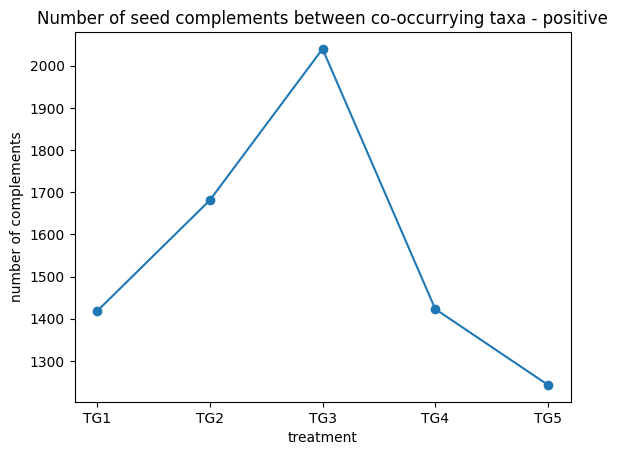

In [37]:
plt.plot(treatments, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()

In [38]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(treatment_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(treatment_parsed_nets.values())
]

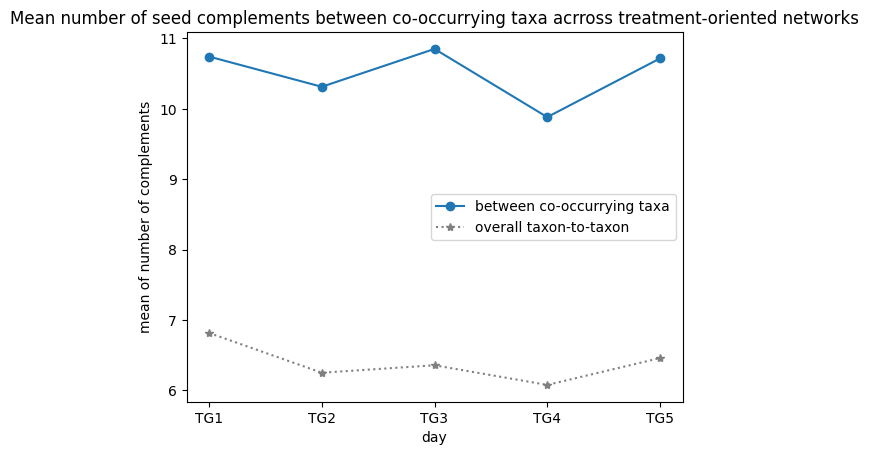

In [39]:
plt.plot(treatments, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(treatments, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross treatment-oriented networks")

plt.legend()

# Show the plot
plt.show()

#### Unique compounds involved in potential cross-feedings of co-occurrying taxa

In [40]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in treatment_parsed_nets.items()
]

lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

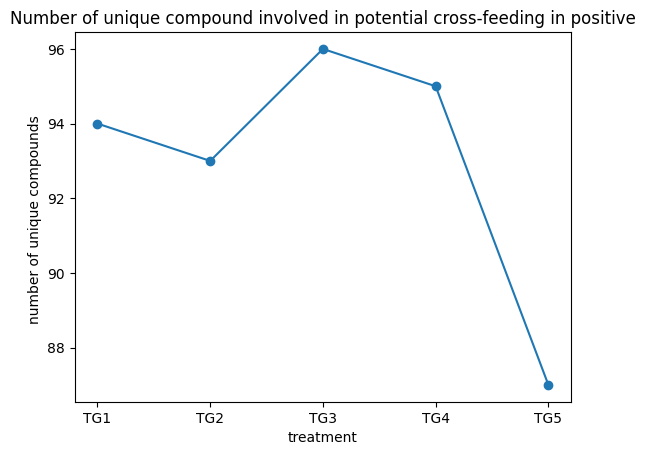

In [41]:
plt.plot(treatments, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [42]:
treatment_set = { i: j for i,j in zip(treatments, unique_compounds_in_cf_of_positive_associated_taxa)}

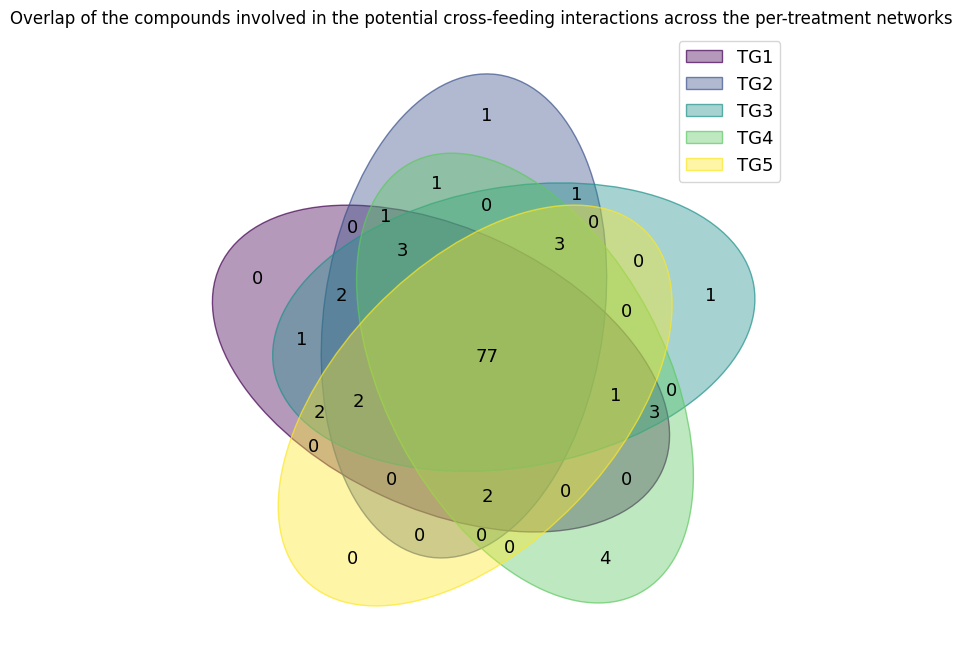

In [43]:
venn(treatment_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-treatment networks")

# Show the plot
plt.show()